In [1]:
import qiskit

In [2]:
qiskit.__qiskit_version__

D:\anaconda\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


{'qiskit-terra': '0.18.1', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.16.0', 'qiskit-aqua': '0.9.4', 'qiskit': '0.29.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [3]:
#Importing necessary packages from qiskit, numpy, math and matplotlib
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute
import numpy as np 
import math as m
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit.tools.visualization import plot_histogram

#Statevector simulator which is the main backend used
S_simulator = Aer.backends(name='statevector_simulator')[0] 

In [4]:
#***************************************************************************************
#  -The functions used in this code were mainly developed by Koch, et al. with minor 
#   adjustments and changes to fit the model and matrix derivations done in Chapter 3 - 
#
#    Title: Fundamentals In Quantum Algorithms: A Tutorial Series Using Qiskit Continued
#    Author: Koch, Daniel and Patel, Saahil and Wessing, Laura and Alsing, Paul M.
#    Date: 2020
#    Availability: 10.48550/ARXIV.2008.10647
#
#***************************************************************************************

In [5]:
def Ub_Mixer(qc, q, beta, Vert):
    #Input: qc (QuantumCircuit) q (QuantumRegister) beta (hyperparameter) Vert (counting array
    #       with external magnetic field values)
    #Applies the quantum logic gates for a U(B,beta) operation using Rx, Ry, and CNOT gates
    qc.barrier()
    for v in np.arange( len(Vert) ):
        qc.rx( -2*beta, q[int(Vert[v][0])] ) #Rx gates
    #CNOT gates for entanglement
    qc.cx( q[0], q[1] )    
    qc.cx( q[2], q[0] )
    for v2 in np.arange( len(Vert) ):
        qc.ry( -2*beta, q[int(Vert[v2][0])] ) #Ry gates

In [6]:
def Uc_Ising(qc, q, gamma, Vert, Edge):
    #Input: qc (QuantumCircuit) q (QuantumRegister) gamma (hyperparameter) Vert (counting array 
    #       with h-values) Edge (array describing qubit/spin relations)
    #Applies the quantum logic gates for a U(C,gamma) operation using Rz and CNOT gates
    J = [1.5,-2.25,1.5] #Values for J 
    for e in np.arange( len(Edge) ): # Z_i Z_j
        qc.cx( q[int(Edge[e][0])], q[int(Edge[e][1])] ) #Ancilla CNOT gates with Rz gate
        qc.rz(-2*gamma*J[e], q[int(Edge[e][1])] ) #Rz gate encoding coupling coefficient (J) values
        qc.cx( q[int(Edge[e][0])], q[int(Edge[e][1])] )
    qc.barrier()
    for v in np.arange( len(Vert) ): # Z_gamma
        qc.rz(-2*gamma*(Vert[v][1]), q[int(Vert[v][0])] ) #Rz gate encoding external magnetic field (h) effects

In [7]:
def Ising_Circuit(qc, q, V, E, beta, gamma, **kwargs):
    #Input: qc (QuantumCircuit) q (QuantumRegister) V (Vert array) E (Edge array) beta (hyperparameter)
    #       gamma (hyperparameter)
    #Forms Quantum Circuit for given geometry parameters in V, E and phase parameters in beta, gamma
    Uc_Ising(qc,q,gamma,V,E) 
    Ub_Mixer(qc,q,beta,V)

In [8]:
def Binary(N, total, LSB):
    #Input: N (integer) total (integer) LSB (string -least significant bit)
    #Gives base-2 binary equivalent of N with LSB notation. 
    #Used for listing down possible states for N qubits
    qubits = int(m.log(total,2))
    b_num = np.zeros(qubits)
    for i in np.arange(qubits):
        if( N/((2)**(qubits-i-1)) >= 1 ):
            if(LSB=='R'):
                b_num[i] = 1
            if(LSB=='L'):
                b_num[int(qubits-(i+1))] = 1
            N = N - 2**(qubits-i-1)
    B = []
    for j in np.arange(len(b_num)):
        B.append(int(b_num[j]))
    return B

In [9]:
def Ising_Energy(V, E, **kwargs):
    #Input: V (Vert array) E (Edge array) 
    #Manually solves for the energy of each configuration based on the set Hamiltonian
    #This is solved for comparative purposes
    Energies = []
    States = []
    J = [1.5,-2.25,1.5] #coupling coefficient values
    for s in np.arange( 2**len(V) ):
        B = Binary(int(s),2**len(V),'L') 
        B2 = []
        for i in np.arange(len(B)):
            if( B[i] == 0 ):
                B2.append(1)  #when binary state is 0, Ising value=1
            else:
                B2.append(-1) #Ising value = -1 otherwise
        state = ''
        energy = 0
        for s2 in np.arange(len(B)):
            state = state+str(B[s2])
            energy = energy - V[s2][1]*B2[s2] #2nd term of cost function
        States.append(state) #Lists down states 
        for j in np.arange( len(E) ):
            energy = energy - J[j] * B2[int(E[j][0])] * B2[int(E[j][1])]
        Energies.append(energy) #Lists down corresponding energy per state
    return Energies,States 

In [10]:
def Ising_Gradient_Descent(qc, q, Circ, V, E, beta, gamma, epsilon, En, step):
    #Input: qc (QuantumCircuit) q (QuantumRegister) Circ (Ising_Circuit function) V (Vert array)
    # E (Edgearray) beta (hyperparameter) gamma (hyperparameter) epsilon (optimization parameter)
    # En (Energies) step (step size)
    # Uses Gradient Descent optimization to determine the next values for gamma and beta 
    params = [ [beta+epsilon,gamma],[beta-epsilon,gamma],[beta,gamma+epsilon],[beta,gamma-epsilon] ]
    ev = []
    for i in np.arange( 4 ):
        q = QuantumRegister(len(V))
        qc= QuantumCircuit(q)
        for hh in np.arange(len(V)):
            qc.h( q[int(hh)] )
        Circ( qc, q, V, E, params[i][0], params[i][1])
        ev.append( E_Expectation_Value( qc, En ) )
    beta_next = beta - ( ev[0] - ev[1] )/( 2.0*epsilon ) * step
    gamma_next = gamma - ( ev[2] - ev[3] )/( 2.0*epsilon ) * step
    return beta_next, gamma_next

In [11]:
def E_Expectation_Value( qc, Energies ):
    #Input: qc (QuantumCircuit) Energies (array)
    #Gets the current statevector and solves its expectation value 
    SV = execute( qc, S_simulator, shots=1 ).result().get_statevector()
    EV = 0
    for i in np.arange( len(SV) ):
        EV = EV + Energies[i] *abs( SV[i] * np.conj(SV[i]) )
    EV = round(EV,4)
    return EV

In [12]:
def Top_States(Energies, Counts, shots, top):
    #Input: Energies (array) Counts (Simulation counts) shots(total shots) top (integer)
    #Displays the top most probable states in the system, and their associated energy
    #Used by Koch et al. for better visualization of the Qiskit output statevector
    # Modified this to take in counts instead of statevectors
    P = []
    S = []
    E = []
    newarr = []
    array1 = list(Counts.keys())
    array2 = list(Counts.values())
    for a in np.arange( top ):
        P.append(-1)
        S.append('no state')
        E.append('no energy')
    for i in np.arange(len(States)):
        new_top = False
        probs = (array2[i]/shots)*100
        state = array1[i]
        energ = Energies[i]
        j = 0
        while( (new_top == False) and (j < top) ):
            if( probs > P[j] ):
                for k in np.arange( int( len(P) - (j+1) ) ):
                    P[int( -1-k )] = P[int( -1-(k+1) )]
                    S[int( -1-k )] = S[int( -1-(k+1) )]
                    E[int( -1-k )] = E[int( -1-(k+1) )]
                P[j] = probs
                S[j] = state
                E[j] = energ
                new_top = True
            j = int(j+1)
    #Code for displaying proper MSB (most significant bit) arrangement
    for n in np.arange( top ):
        bit = list(S[n])
        index = 0
        copy1 = bit[index]
        bit[index] = bit[index + 2]
        bit[index + 2] = copy1
        bitstring = ''.join(bit)
        newarr.append(bitstring)
    for s in np.arange( top ):
        print('State ' + '|',newarr[s],'>'+' Probability: ',round(P[s],2),'%',' Energy: ',round(E[s],2))

In [13]:
#Parameters for Gradient Descent
epsilon = 0.001 
#step_size=0.01
step_size = 0.001
delta = 0.002
#-------------------------------------------------------
#Geometry parameters and external magnetic field
Vert = [ [0,0.01] , [1,0.01] , [2,0.01] ] #h
Edge = [ [0,1],[1,2],[0,2] ] #relationship between spins/qubits
#-------------------------------------------------------
#Initial values for optimization 
Energies,States = Ising_Energy(Vert,Edge)
EV = 100
EV_old = 1000
EV_min = 1000
#-------------------------------------------------------
#Phase parameters/optimization hyperparameters
gamma = -6.5
beta = -2.5
s = 0
#-------------------------------------------------------
#Main part of the algorithm which attempts to find absolute minimum energy of quantum system
while( (abs( EV - EV_old ) > delta) and ( EV < EV_old ) ):
    q = QuantumRegister(len(Vert))
    c = ClassicalRegister(len(Vert))
    qc= QuantumCircuit(q,c)
    for hh in np.arange(len(Vert)):
        qc.h( q[int(hh)] )
    if( s != 0 ):
        beta,gamma = Ising_Gradient_Descent(qc,q,Ising_Circuit,Vert,Edge,beta,gamma,epsilon,Energies,step_size)
    Ising_Circuit( qc, q, Vert, Edge, beta, gamma)
    EV_old = EV
    EV = E_Expectation_Value( qc, Energies )
    if( EV < EV_min ):
        Params = [beta,gamma]
        EV_min = EV
    s = int(s+1)
    print('E(\u03B3,\u03B2): ',np.around(EV,3),' \u03B3 = ',round(gamma,6),' \u03B2 = ',round(beta,6),'    step =',s)

E(γ,β):  -0.965  γ =  -6.5  β =  -2.5     step = 1
E(γ,β):  -1.04  γ =  -6.492  β =  -2.4966     step = 2
E(γ,β):  -1.114  γ =  -6.4841  β =  -2.4933     step = 3
E(γ,β):  -1.184  γ =  -6.4763  β =  -2.4901     step = 4
E(γ,β):  -1.252  γ =  -6.4686  β =  -2.487     step = 5
E(γ,β):  -1.318  γ =  -6.461  β =  -2.484     step = 6
E(γ,β):  -1.381  γ =  -6.4536  β =  -2.4811     step = 7
E(γ,β):  -1.441  γ =  -6.44635  β =  -2.4783     step = 8
E(γ,β):  -1.498  γ =  -6.43925  β =  -2.4756     step = 9
E(γ,β):  -1.551  γ =  -6.43235  β =  -2.473     step = 10
E(γ,β):  -1.601  γ =  -6.4257  β =  -2.47045     step = 11
E(γ,β):  -1.648  γ =  -6.4192  β =  -2.46805     step = 12
E(γ,β):  -1.693  γ =  -6.4129  β =  -2.46565     step = 13
E(γ,β):  -1.734  γ =  -6.40685  β =  -2.46335     step = 14
E(γ,β):  -1.772  γ =  -6.401  β =  -2.46115     step = 15
E(γ,β):  -1.807  γ =  -6.3954  β =  -2.45905     step = 16
E(γ,β):  -1.84  γ =  -6.39  β =  -2.457     step = 17
E(γ,β):  -1.87  γ =  -6.3848  

In [14]:
#Checking how well the algorithm found the lowest energy
print(Energies,States)

[-0.78, 5.24, -2.26, -2.24, -2.26, -2.24, 5.26, -0.72] ['000', '100', '010', '110', '001', '101', '011', '111']


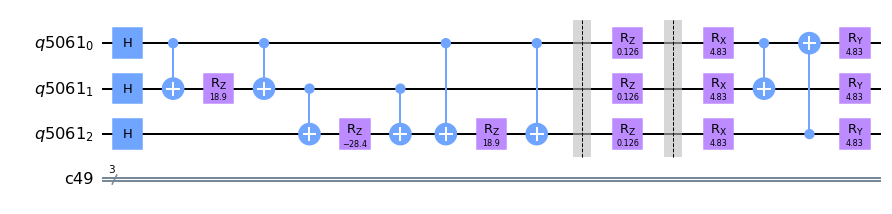

In [15]:
#Quantum circuit visualization using matplotlib
qc.draw(output='mpl')

In [16]:
#Adding measurement so that quantum circuit can be run on qasm simulator or actual quantum computers
qc.measure([0,1,2],[0,1,2])
qasm_simulator = Aer.get_backend('qasm_simulator')

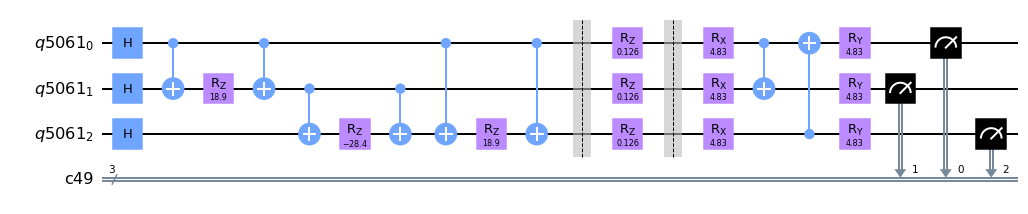

In [17]:
#Visualization of quantum circuit with measurements
qc.draw(output='mpl')

In [18]:
#Running the circuit via the QASM simulator for histogram visualization
import itertools

def run_circuit_qasm(circuit,shots):
    exec = execute(circuit, backend = qasm_simulator, shots = shots)
    result = exec.result()
    counts = result.get_counts(circuit)
    #Code for displaying all possible states at the cost of memory
    all_bitstrings = ("".join(states) for states in itertools.product("01", repeat=3))
    counts = {key: counts.get(key, 0) for key in all_bitstrings}
    return result, counts

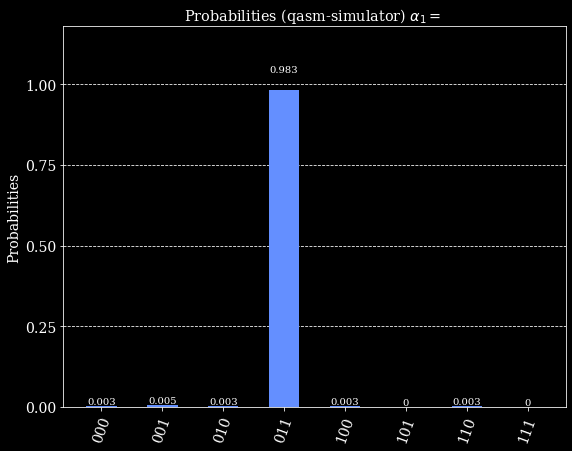

In [19]:
#Matplotlib style visualization of probability distribution
from matplotlib import style
from matplotlib import pyplot as plt

style.use("dark_background")

params = {#'figure.figsize': (20, 17),
          'font.family': 'DeJavu Serif',
          'font.serif':'Times New Roman',
         #'axes.labelsize': 'xx-large',
          #'legend.loc': 'upper left',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

shots = 1000
run,counts_sim = run_circuit_qasm(qc,shots)
plot_histogram(counts_sim, figsize = (9,7), title =r'Probabilities (qasm-simulator) $\alpha_1 = $ ')

In [20]:
#States,corresponding probabilities and energies arranged descending
Top_States(Energies,counts_sim,shots,8)

State | 110 > Probability:  98.3 %  Energy:  -2.24
State | 100 > Probability:  0.5 %  Energy:  5.24
State | 000 > Probability:  0.3 %  Energy:  -0.78
State | 010 > Probability:  0.3 %  Energy:  -2.26
State | 001 > Probability:  0.3 %  Energy:  -2.26
State | 011 > Probability:  0.3 %  Energy:  5.26
State | 101 > Probability:  0.0 %  Energy:  -2.24
State | 111 > Probability:  0.0 %  Energy:  -0.72


In [21]:
#Connecting to the IBM cloud backend
from qiskit import IBMQ

IBMQ.save_account('9e3d0959293d1ede45d5a77e4f26528b6e996680d58c590393f87ad347b5ec58cb86a21ac07ad4eae63659e5a8d4038054de693eb7b7021fdc3307e55efaecea')
IBMQ.load_account()

configrc.store_credentials:WARNING:2022-04-19 23:28:13,737: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [22]:
#Checking of quantum computer queues

provider = IBMQ.get_provider("ibm-q")
for backend in provider.backends():
    try:
        qubit_count = len(backend.properties().qubits)
    except:
        qubit_count = "simulated"
    print(f"{backend.name()} has {backend.status().pending_jobs} queued and {qubit_count} qubits")    

ibmq_qasm_simulator has 3 queued and simulated qubits
ibmq_armonk has 5 queued and 1 qubits
ibmq_santiago has 11 queued and 5 qubits
ibmq_bogota has 34 queued and 5 qubits
ibmq_lima has 3 queued and 5 qubits
ibmq_belem has 1 queued and 5 qubits
ibmq_quito has 1 queued and 5 qubits
simulator_statevector has 3 queued and simulated qubits
simulator_mps has 3 queued and simulated qubits
simulator_extended_stabilizer has 3 queued and simulated qubits
simulator_stabilizer has 3 queued and simulated qubits
ibmq_manila has 5 queued and 5 qubits


In [23]:
#Code for monitoring quantum computer run
from qiskit.tools.monitor import job_monitor

backend = provider.get_backend("ibmq_lima")
job = execute(qc, backend = backend, shots = 1000)
job_monitor(job)

Job Status: job has successfully run


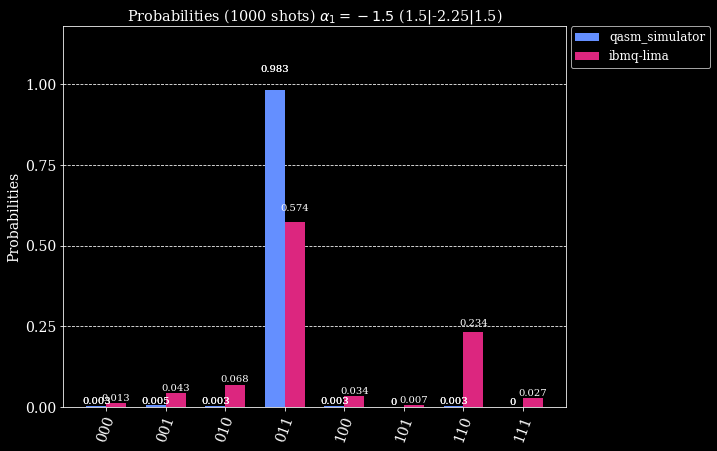

In [24]:
#Get number of occurences per configuration
result = job.result()
counts_qc = result.get_counts(qc)

#Visualization of results
legend = ['qasm_simulator','ibmq-lima']
plot_histogram([counts_sim,counts_qc], figsize = (9,7),  legend= legend,
               title=r'Probabilities (1000 shots) $\alpha_1 = -1.5$ (1.5$\vert$-2.25$\vert$1.5)')

In [25]:
#View specific run parameters and results 
print(result)

Result(backend_name='ibmq_lima', backend_version='1.0.35', qobj_id='949e0f66-d97e-42b2-8ae7-17b0879cf7b2', job_id='625ed5343ba19993dd5653e4', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 13, '0x1': 43, '0x2': 68, '0x3': 574, '0x4': 34, '0x5': 7, '0x6': 234, '0x7': 27}), header=QobjExperimentHeader(clbit_labels=[['c49', 0], ['c49', 1], ['c49', 2]], creg_sizes=[['c49', 3]], global_phase=2.3561944901923475, memory_slots=3, metadata={}, n_qubits=5, name='circuit-65646', qreg_sizes=[['q', 5]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4]]))], date=2022-04-19 23:29:55+08:00, status=Successful completion, status=QobjHeader(backend_name='ibmq_lima', backend_version='1.0.35'), execution_id='8e06e302-bff5-11ec-877b-b02628f7f59e', time_taken=4.021468877792358, error=None, client_version={'qiskit': '0.29.0'})


In [26]:
#Checking of raw data from result
print(counts_qc)
print(States)
print(Energies)

{'000': 13, '001': 43, '010': 68, '011': 574, '100': 34, '101': 7, '110': 234, '111': 27}
['000', '100', '010', '110', '001', '101', '011', '111']
[-0.78, 5.24, -2.26, -2.24, -2.26, -2.24, 5.26, -0.72]


In [28]:
#Better visualization of given data 
Top_States(Energies,counts_qc,shots,8)

State | 110 > Probability:  57.4 %  Energy:  -2.24
State | 011 > Probability:  23.4 %  Energy:  5.26
State | 010 > Probability:  6.8 %  Energy:  -2.26
State | 100 > Probability:  4.3 %  Energy:  5.24
State | 001 > Probability:  3.4 %  Energy:  -2.26
State | 111 > Probability:  2.7 %  Energy:  -0.72
State | 000 > Probability:  1.3 %  Energy:  -0.78
State | 101 > Probability:  0.7 %  Energy:  -2.24
